La ruta más lógica y menos costosa consiste en integrar en paralelo Prop1, Prop2, Prop3 → Prop4, obteniendo el consenso en Prop4.



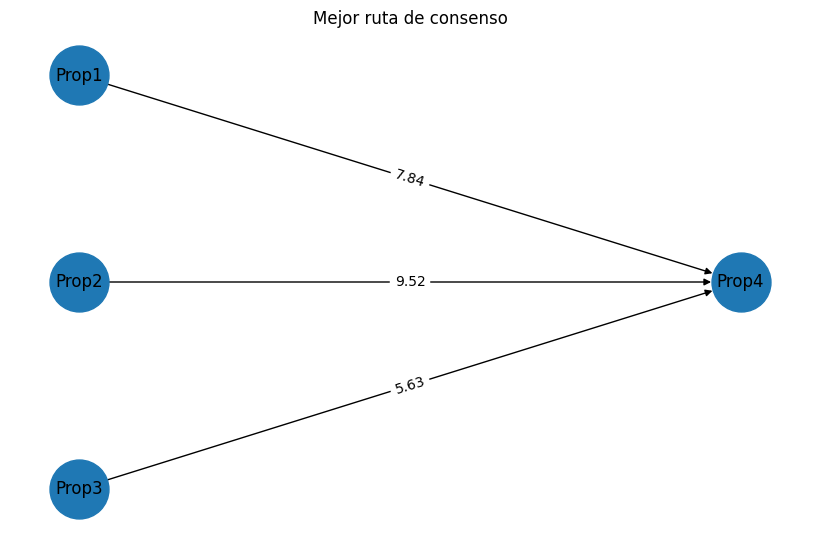

Mostrando las 10 rutas más económicas:

Ruta paralelo: (Prop1->Prop4 (c=7.84, movedU=1, movedUaR=1), Prop2->Prop4 (c=9.52, movedU=2, movedUaR=0), Prop3->Prop4 (c=5.63, movedU=1, movedUaR=1))  Coste total: 23.00
Ruta mixta: (Prop2->Prop1 (c=6.56, movedU=1, movedUaR=1), Prop1->Prop4 (c=11.76, movedU=3, movedUaR=1), Prop3->Prop4 (c=5.63, movedU=1, movedUaR=1))  Coste total: 23.96
Ruta paralelo: (Prop1->Prop3 (c=12.90, movedU=1, movedUaR=1), Prop2->Prop3 (c=9.76, movedU=1, movedUaR=1), Prop4->Prop3 (c=4.23, movedU=3, movedUaR=0))  Coste total: 26.88
Ruta mixta: (Prop1->Prop4 (c=7.84, movedU=1, movedUaR=1), Prop4->Prop3 (c=9.86, movedU=4, movedUaR=1), Prop2->Prop3 (c=9.76, movedU=1, movedUaR=1))  Coste total: 27.46
Ruta mixta: (Prop2->Prop4 (c=14.29, movedU=3, movedUaR=0), Prop4->Prop3 (c=15.49, movedU=5, movedUaR=2))  Coste total: 29.78
Ruta mixta: (Prop2->Prop3 (c=17.07, movedU=1, movedUaR=2), Prop3->Prop4 (c=14.08, movedU=4, movedUaR=2))  Coste total: 31.16
Ruta paralelo: (Prop2->Prop1 (

In [21]:
import itertools
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# --- Parámetros de entrada -----------------------------------------------------
data = {
    "Prop1": ["U2", "U1", "U3", "R4", "R5"],
    "Prop2": ["U2", "U4", "U6", "R1", "R3"],
    "Prop3": ["U1", "U5", "U7", "U8", "U9", "R6", "R2"],
    "Prop4": ["U3", "U8", "R9", "U9", "R7", "U10", "U11", "U12", "R1"],
}
proposals = list(data.keys())

closeness_matrix = np.array([
    [1.0, 0.6, 0.3, 0.5],
    [0.6, 1.0, 0.4, 0.2],
    [0.3, 0.4, 1.0, 0.7],
    [0.5, 0.2, 0.7, 1.0],
])

# Parámetros de coste
epsilon = 0.01  # evita división por cero
alpha   = 1.0   # coste base para nuevos apoyos
beta    = 3.0   # coste extra para anular rechazos
# Número máximo de rutas a mostrar
top_n   = 10

# Conjuntos originales de apoyos y rechazos
original_supports = {
    p: set(u for u in lst if u.startswith('U'))
    for p, lst in data.items()
}
original_rejects = {
    p: set('U' + e[1:] for e in lst if e.startswith('R'))
    for p, lst in data.items()
}

# --- Función de simulación ---------------------------------------------------
def simulate_sequence(seq_edges):
    """
    Simula dinámicamente movimientos de apoyos (y anulación de rechazos)
    seq_edges: lista de tuplas (src, dst)
    Retorna:
      transitions: [( "A->B", cost, movedU, movedUaR ), ...]
      total_cost: coste acumulado
    """
    dyn_supports = {p: set(original_supports[p]) for p in proposals}
    transitions = []
    total_cost = 0.0
    for a, b in seq_edges:
        movers = dyn_supports[a] - dyn_supports[b]
        movedUaR = sum(1 for u in movers if u in original_rejects[b])
        movedU   = len(movers) - movedUaR
        i, j = proposals.index(a), proposals.index(b)
        base = 1.0 / (closeness_matrix[i][j] + epsilon)
        cost = alpha * base * movedU + beta * base * movedUaR
        # actualizar estados
        dyn_supports[b] |= movers
        dyn_supports[a] -= movers
        transitions.append((f"{a}->{b}", cost, movedU, movedUaR))
        total_cost += cost
    return transitions, total_cost

# --- Generación de rutas -----------------------------------------------------
routes = []
# 1) Ruta serie: permutaciones de 4 propuestas en cadena (3 transiciones)
for perm in itertools.permutations(proposals, 4):
    edges = list(zip(perm, perm[1:]))
    trans, cost = simulate_sequence(edges)
    routes.append(("serie", edges, trans, cost))
# 2) Ruta paralelo: combinación fija de 3 fuentes -> destino
for dest in proposals:
    sources = [p for p in proposals if p != dest]
    edges = [(src, dest) for src in sources]
    trans, cost = simulate_sequence(edges)
    routes.append(("paralelo", edges, trans, cost))
# 3) Ruta mixta: chain de 2 + salto de la fuente restante
for chain in itertools.permutations(proposals, 3):
    rest = [p for p in proposals if p not in chain]
    for src in rest:
        edges = [
            (chain[0], chain[1]),
            (chain[1], chain[2]),
            (src,      chain[2])
        ]
        trans, cost = simulate_sequence(edges)
        routes.append(("mixta", edges, trans, cost))
# Ordenar todas las rutas por coste creciente
routes_sorted = sorted(routes, key=lambda x: x[3])

# --- Salida en terminal ------------------------------------------------------
if __name__ == '__main__':
    # 1) Descripción en lenguaje natural
    best_kind, best_edges, best_trans, best_cost = routes_sorted[0]
    if best_kind == 'serie':
        seq = [best_edges[0][0]] + [b for (_, b) in best_edges]
        desc = ("La ruta más lógica y menos costosa consiste en integrar " +
                "→".join(seq) +
                f", obteniendo el consenso final en {seq[-1]}." )
    elif best_kind == 'paralelo':
        dest = best_edges[0][1]
        srcs = [a for (a, _) in best_edges]
        desc = (f"La ruta más lógica y menos costosa consiste en integrar en paralelo " +
                f"{', '.join(srcs)} → {dest}, obteniendo el consenso en {dest}." )
    else:
        a1,b1 = best_edges[0]
        a2,b2 = best_edges[1]
        a3,b3 = best_edges[2]
        desc = (f"La ruta más lógica y menos costosa comienza con {a1}->{b1}, luego {a2}->{b2} " +
                f"y finalmente {a3}->{b3}, obteniendo el consenso en {b3}.")
    print(desc + "\n")

    # 2) Dibujo del grafo de la mejor ruta
    G = nx.DiGraph()
    for (a, b), (edge, cost, u, r) in zip(best_edges, best_trans):
        G.add_edge(a, b, weight=cost)
    plt.figure(figsize=(8, 5))
    pos = {}
    kind = best_kind
    if kind == 'serie':
        nodes = [best_edges[0][0]] + [b for (_, b) in best_edges]
        pos = {nodes[i]: (i, 0) for i in range(len(nodes))}
    elif kind == 'paralelo':
        srcs = [a for (a, _) in best_edges]
        for i, src in enumerate(srcs):
            pos[src] = (0, len(srcs)-1 - i)
        dest = best_edges[0][1]
        pos[dest] = (1, (len(srcs)-1)/2)
    else:  # mixta
        chain_nodes = [best_edges[0][0], best_edges[0][1], best_edges[1][1]]
        for i, node in enumerate(chain_nodes):
            pos[node] = (i, 1)
        rest_node = best_edges[2][0]
        pos[rest_node] = (2, 0)
    nx.draw(G, pos, with_labels=True, arrows=True, node_size=1800)
    edge_labels = {(u, v): f"{d['weight']:.2f}" for u, v, d in G.edges(data=True)}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
    plt.title('Mejor ruta hacia el consenso')
    plt.axis('off')
    plt.show()

    # 3) Listado del TOP N rutas
    print(f"Mostrando las {top_n} rutas más económicas:\n")
    for kind, edges, trans, total in routes_sorted[:top_n]:
        parts = [
            f"{edge} (c={c:.2f}, movedU={u}, movedUaR={r})"
            for (edge, c, u, r) in trans if c > 0
        ]
        print(f"Ruta {kind}: ({', '.join(parts)})  Coste total: {total:.2f}")

